In [ ]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import polyflexmd.data_analysis.plot.msd as msd_plot
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.transform.msdlm as transform_msdlm
import polyflexmd.data_analysis.plot.utils as plot_utils
import pathlib

from scipy.signal import savgol_filter

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

sns.set_style("darkgrid")

params = {
    'axes.labelsize': 10,
    'figure.dpi': 300,
    "figure.figsize": plot_utils.get_figure_size(width=1, n_rows=1)
}

plt.rcParams.update(params)

In [233]:
def read_msd_lm_df(path):
    df_msd_lm = pd.read_csv(path)
    df_msd_lm["t/LJ"] = df_msd_lm["t"] * 0.0025
    df_msd_lm["t/LJ"] = df_msd_lm["t/LJ"] - df_msd_lm["t/LJ"].min()
    #return df_msd_lm.loc[df_msd_lm["t/LJ"]].copy()
    return df_msd_lm


def with_msdlm_bin_avg(df_msdlm: pd.DataFrame, bin_size: int = 100):
    bins = np.linspace(df_msdlm.index.min(), df_msdlm.index.max(), num=df_msdlm.shape[0] // bin_size)
    binned_idx = pd.cut(df_msdlm.index, bins)
    binned_msdlm_avg = df_msdlm.groupby(binned_idx).agg({
        "dr_N^2": "mean",
        "delta dr_N^2": "mean",
        "t/LJ": lambda ts: ts.min() + (ts.max() - ts.min()) / 2
    })
    return binned_msdlm_avg.set_index("t/LJ")


def with_savgol(df_msdlm: pd.DataFrame, window_size: int, polyorder: int):
    df_msdlm = df_msdlm.copy()
    df_msdlm["dr_N^2"] = savgol_filter(x=df_msdlm["dr_N^2"], window_length=window_size, polyorder=polyorder)
    return df_msdlm


def with_msdlm_ma(df_msdlm: pd.DataFrame, window_size: int = 10, window_type="hamming"):
    df_msdlm["dr_N^2"] = df_msdlm["dr_N^2"].rolling(window_size, min_periods=1, win_type=window_type).mean()
    return df_msdlm.dropna()


def get_ete_mean(path):
    df_ete = pd.read_csv(path)

    def calc_mean_R(df):
        R = 0
        for dim in ["x", "y", "z"]:
            R += (df[f"R_{dim}"] ** 2).mean()
        return R

    return df_ete.groupby("t").apply(calc_mean_R).rename("R^2")


def smooth(x, window_len=11, window='hanning'):
    if window_len < 3:
        return x

    s = np.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
    #print(len(s))
    if window == 'flat':  #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    y = np.convolve(w / w.sum(), s, mode='valid')
    return y

In [234]:
N = 63
zeta = 1
b = .97
L_contour = N * b

experiments = [
    {
        "n": 17,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "m_e": 1.0,
        "l_K": 6.02,
        "label": "$l_K/L=6.02$, $\\zeta_e=1$"
    },
    {
        "n": 18,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K-vary-d_end/18-EEA1_short+Rab5_10x-free_chain/ef6e4e76"),
        "zeta_e": 10.0,
        "m_e": 1.5,
        "l_K": 6.02,
        "label": "$l_K/L=6.02$, $\\zeta_e=10$"
    },
    {
        "n": 19,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/19-EEA1_short-lp_bonded_like-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "m_e": 1.0,
        "l_K": 0.6,
        "label": "$l_K/L=0.6$, $\\zeta_e=1$"
    },
]

for experiment in experiments:
    print(f"Reading {experiment['path']}...")
    msd_avg_file = "lm_msd_avg-1000"
    df_raw = read_msd_lm_df(experiment["path"] / "data" / "processed" / "lm_msd.csv")
    df_agg = read_msd_lm_df(experiment["path"] / "data" / "processed" / "lm_msd_avg-1000.csv")
    df_agg = pd.concat([df_raw.loc[df_raw["t/LJ"] <= 100], df_agg])
    df_agg = df_agg.sort_values(by="t/LJ")
    df_agg = df_agg.groupby((df_agg["t"] % 100 == 0).cumsum(), as_index=False).agg({
        "t": "min",
        "dr_N^2": "mean",
        "delta dr_N^2": "mean",
        "t/LJ": "min",
    })
    df_agg.drop(df_agg.loc[df_agg["t/LJ"]==0.0].index, inplace=True)
    experiment["df_msdlm raw"] = df_agg

Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/ef6e4e76...
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K-vary-d_end/18-EEA1_short+Rab5_10x-free_chain/ef6e4e76...
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/19-EEA1_short-lp_bonded_like-free_chain/ef6e4e76...


In [235]:
experiments[0]["df_msdlm raw"]

,t,dr_N^2,delta dr_N^2,t/LJ
2,35000100,0.172678,0.020836,0.25
3,35000200,0.351199,0.040678,0.50
4,35000300,0.548488,0.062672,0.75
5,35000400,0.749257,0.085347,1.00
6,35000500,0.953194,0.113249,1.25
...,...,...,...,...
80077,800000000,177912.881250,20707.412589,2000000.00
80078,800010000,177925.539062,20691.589194,2000025.00
80079,800020000,177889.307292,20677.692031,2000050.00
80080,800030000,177912.812500,20679.761792,2000075.00


In [236]:
bin_size = 3
window_size = 10

for experiment in experiments:
    df = experiment["df_msdlm raw"].copy()
    print("Savgol ...")
    #with_savgol(df_msdlm=df, window_size=window_size, polyorder=6)
    #df.reset_index(inplace=True)
    experiment["df_msdlm"] = df

Savgol ...
Savgol ...
Savgol ...


In [237]:
def get_rouse_msdlm_df(ts):
    tau_R = 1 / (3 * np.pi ** 2) * N ** 2 * b ** 2 * zeta
    R = N * b ** 2
    msdlm = rouse.rouse_msdlm(ts, R_sq=R, tau_R=tau_R, N=N)
    df_theor = pd.DataFrame({
        "t/LJ": ts,
        "dr_N^2": msdlm
    })
    return df_theor


df_rouse_msdlm = get_rouse_msdlm_df(experiments[0]["df_msdlm"]["t/LJ"])
df_rouse_msdlm

,t/LJ,dr_N^2
2,0.25,0.767611
3,0.50,1.172139
4,0.75,1.485319
5,1.00,1.751209
6,1.25,1.986880
...,...,...
80077,2000000.00,190495.757189
80078,2000025.00,190498.138141
80079,2000050.00,190500.519094
80080,2000075.00,190502.900046


Plotting 17 ...
Plotting 18 ...
Plotting 19 ...


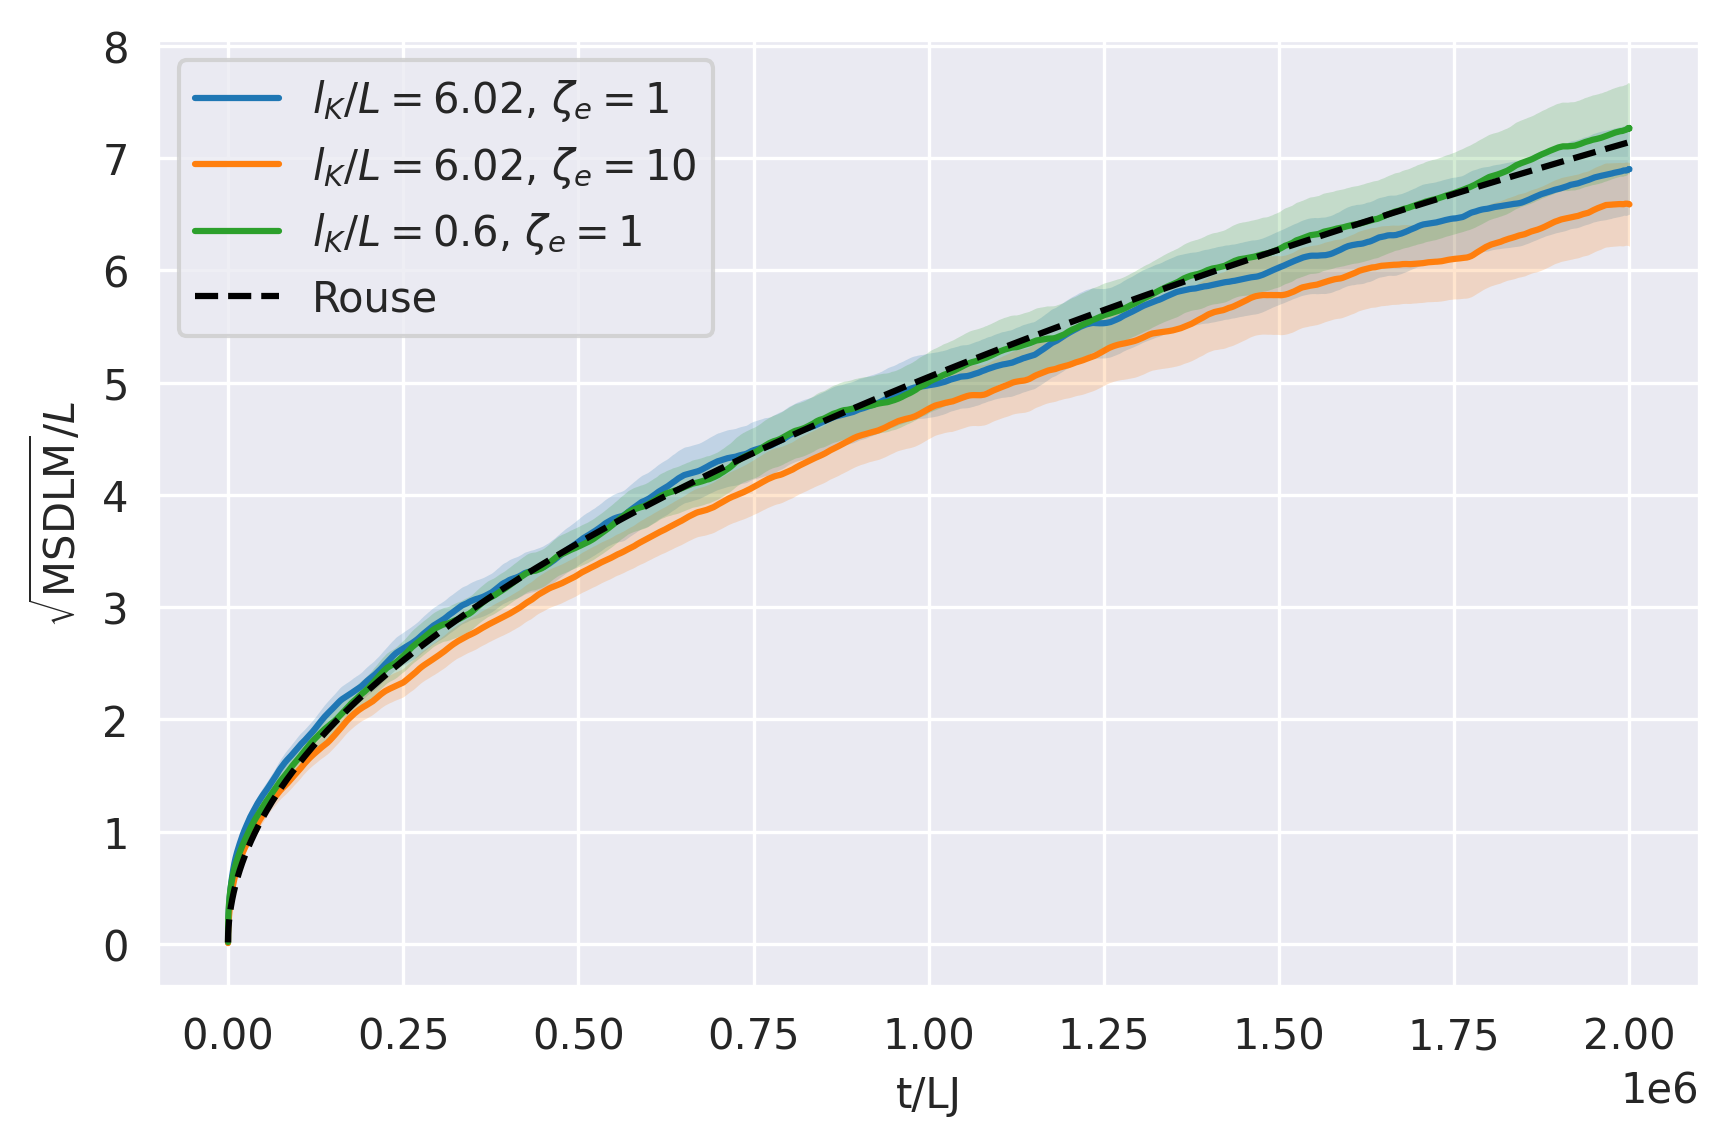

In [238]:
fig, ax = plt.subplots()

for experiment, color in zip(experiments, sns.color_palette()):
    print(f"Plotting {experiment['n']} ...")

    msd_plot.plot_MSD(
        experiment["df_msdlm"],
        log_scale=False,
        l_K=experiment["l_K"],
        L_contour=L_contour,
        zeta=zeta,
        zeta_e=experiment["zeta_e"],
        col="dr_N^2",
        label=experiment["label"],
        ax=ax,
        title="",
        ylabel="",
        xlabel="",
        scatter=False,
        marker_size=2,
        color=color
    )

ax.plot(df_rouse_msdlm["t/LJ"], np.sqrt(df_rouse_msdlm["dr_N^2"]) / L_contour, label="Rouse", linestyle="--",
        color="black")

ax.set(xlabel="t/LJ", ylabel="$\sqrt{\\mathrm{MSDLM}}/L$")

ax.legend(loc="upper left")

Plotting 17 ...
Plotting 18 ...
Plotting 19 ...


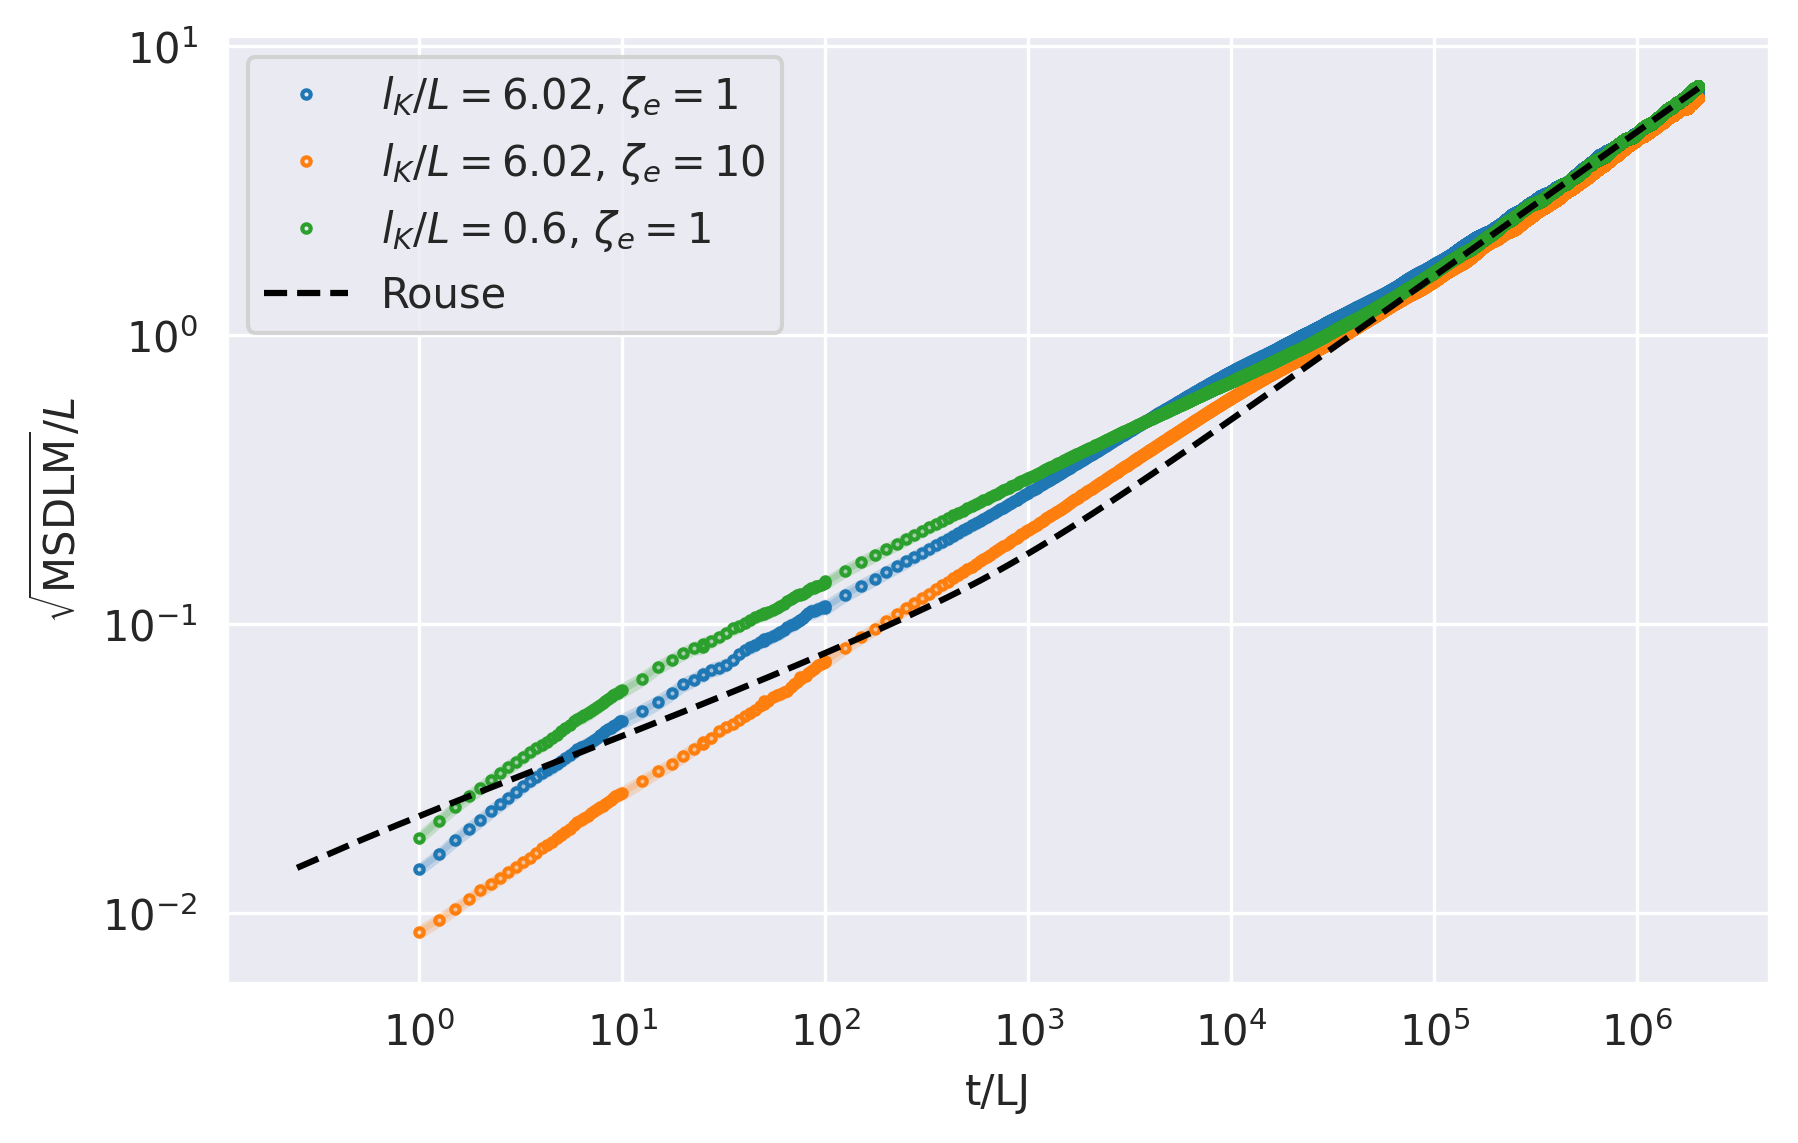

In [239]:
fig, ax = plt.subplots()

for experiment, color in zip(experiments, sns.color_palette()):
    print(f"Plotting {experiment['n']} ...")

    msd_plot.plot_MSD(
        experiment["df_msdlm"],
        log_scale=True,
        l_K=experiment["l_K"],
        L_contour=L_contour,
        zeta=zeta,
        zeta_e=experiment["zeta_e"],
        col="dr_N^2",
        label=experiment["label"],
        ax=ax,
        title="",
        ylabel="",
        xlabel="",
        scatter=True,
        marker_size=2,
        color=color
    )

ax.plot(df_rouse_msdlm["t/LJ"], np.sqrt(df_rouse_msdlm["dr_N^2"]) / L_contour, label="Rouse", linestyle="--",
        color="black")

ax.set(xlabel="t/LJ", ylabel="$\sqrt{\\mathrm{MSDLM}}/L$")

ax.legend(loc="upper left")

In [240]:
from scipy.special import gamma


def tau_1_rod_limit(tau_0: float, L: float, l_p: float, l_b: float) -> float:
    return tau_0 * L ** 4 / (l_p * l_b ** 3)


def tau_1_coil_limit(tau_0: float, l_p: float, l_b: float) -> float:
    return tau_0 * (l_p / l_b) ** 3


def ete_ac_interim_t_large(t, tau_0, L, l_b, l_p, k=1):
    # Nikoubashman (C9)
    tau_rot = tau_0 * L ** 2 * l_p / l_b ** 3
    return k * np.exp(-t / tau_rot)


def ete_ac_interim_t_small(t, tau_0, L, l_b, l_p, k=1):
    # Nikoubashman (C10)
    return 1 - k * l_b ** (9 / 4) / (L * l_p ** (5 / 4)) * (t / tau_0) ** (3 / 4)


def ete_ac_rod_limit_t_large(t, tau_0, L, l_b, k=1):
    # Nikoubashman (C3) 
    # t > tau_1
    tau_rot = tau_0 * (L / l_b) ** 3
    return k * np.exp(-t / tau_rot)


def ete_ac_rod_limit_t_small(t, tau_0, L, l_b, l_p, k=1):
    # Nikoubashman (C4)
    # tau_0 < t < tau_1 
    return k * np.exp(
        -(8 * gamma(1 / 4)) / (3 * np.pi) * l_b ** (9 / 4) / (L ** 2 * l_p ** (1 / 4)) * (t / tau_0) ** (3 / 4))



,alpha,delta alpha,delta t,interval,count
t/LJ,,,,,
NaN,NaN,NaN,NaN,NaN,NaN
0.75,1.107818,0.136145,0.375,"(0.75, 1.5)",4.0
1.75,1.094177,0.076293,1.125,"(1.75, 4.0)",10.0
4.25,0.922989,0.047939,2.875,"(4.25, 10.0)",24.0
12.50,0.847431,0.094681,6.250,"(12.5, 25.0)",7.0
27.50,0.777989,0.050265,20.000,"(27.5, 67.5)",18.0
70.00,0.813678,0.096161,40.000,"(70.0, 150.0)",17.0
175.00,0.767028,0.063097,125.000,"(175.0, 425.0)",11.0
450.00,0.802426,0.037754,337.500,"(450.0, 1125.0)",28.0


Ref 2/3:  0.6666666666666666
Ref 3/4:  0.75


,$\zeta_e$,$l_K/L$,$\tau_1$,$\tau_b$,$\tau_0$,$\alpha_{min}$,$\Delta \alpha_{min}$,$\alpha_{m}$,$\Delta \alpha_{m}$,$\alpha_{ref}$
0,1.0,6.02,78162.53,11.00,0.94,0.723,0.005,0.796,0.043,0.750000
1,10.0,6.02,781625.32,1.65,9.41,0.773,0.005,0.890,0.059,0.750000
2,1.0,0.60,6352.27,11.00,0.94,0.648,0.008,0.717,0.057,0.666667


\begin{tabular}{rrlllrr}
\toprule
$\zeta_e$ & $l_K/L$ & $\tau_1$ & $\tau_b$ & $\tau_0$ & $\alpha_{min}$ & $\Delta \alpha_{min}$ \\
\midrule
1.000000 & 6.020000 & 78162.53 & 11.00 & 0.94 & 0.723000 & 0.005000 \\
10.000000 & 6.020000 & 781625.32 & 1.65 & 9.41 & 0.773000 & 0.005000 \\
1.000000 & 0.600000 & 6352.27 & 11.00 & 0.94 & 0.648000 & 0.008000 \\
\bottomrule
\end{tabular}


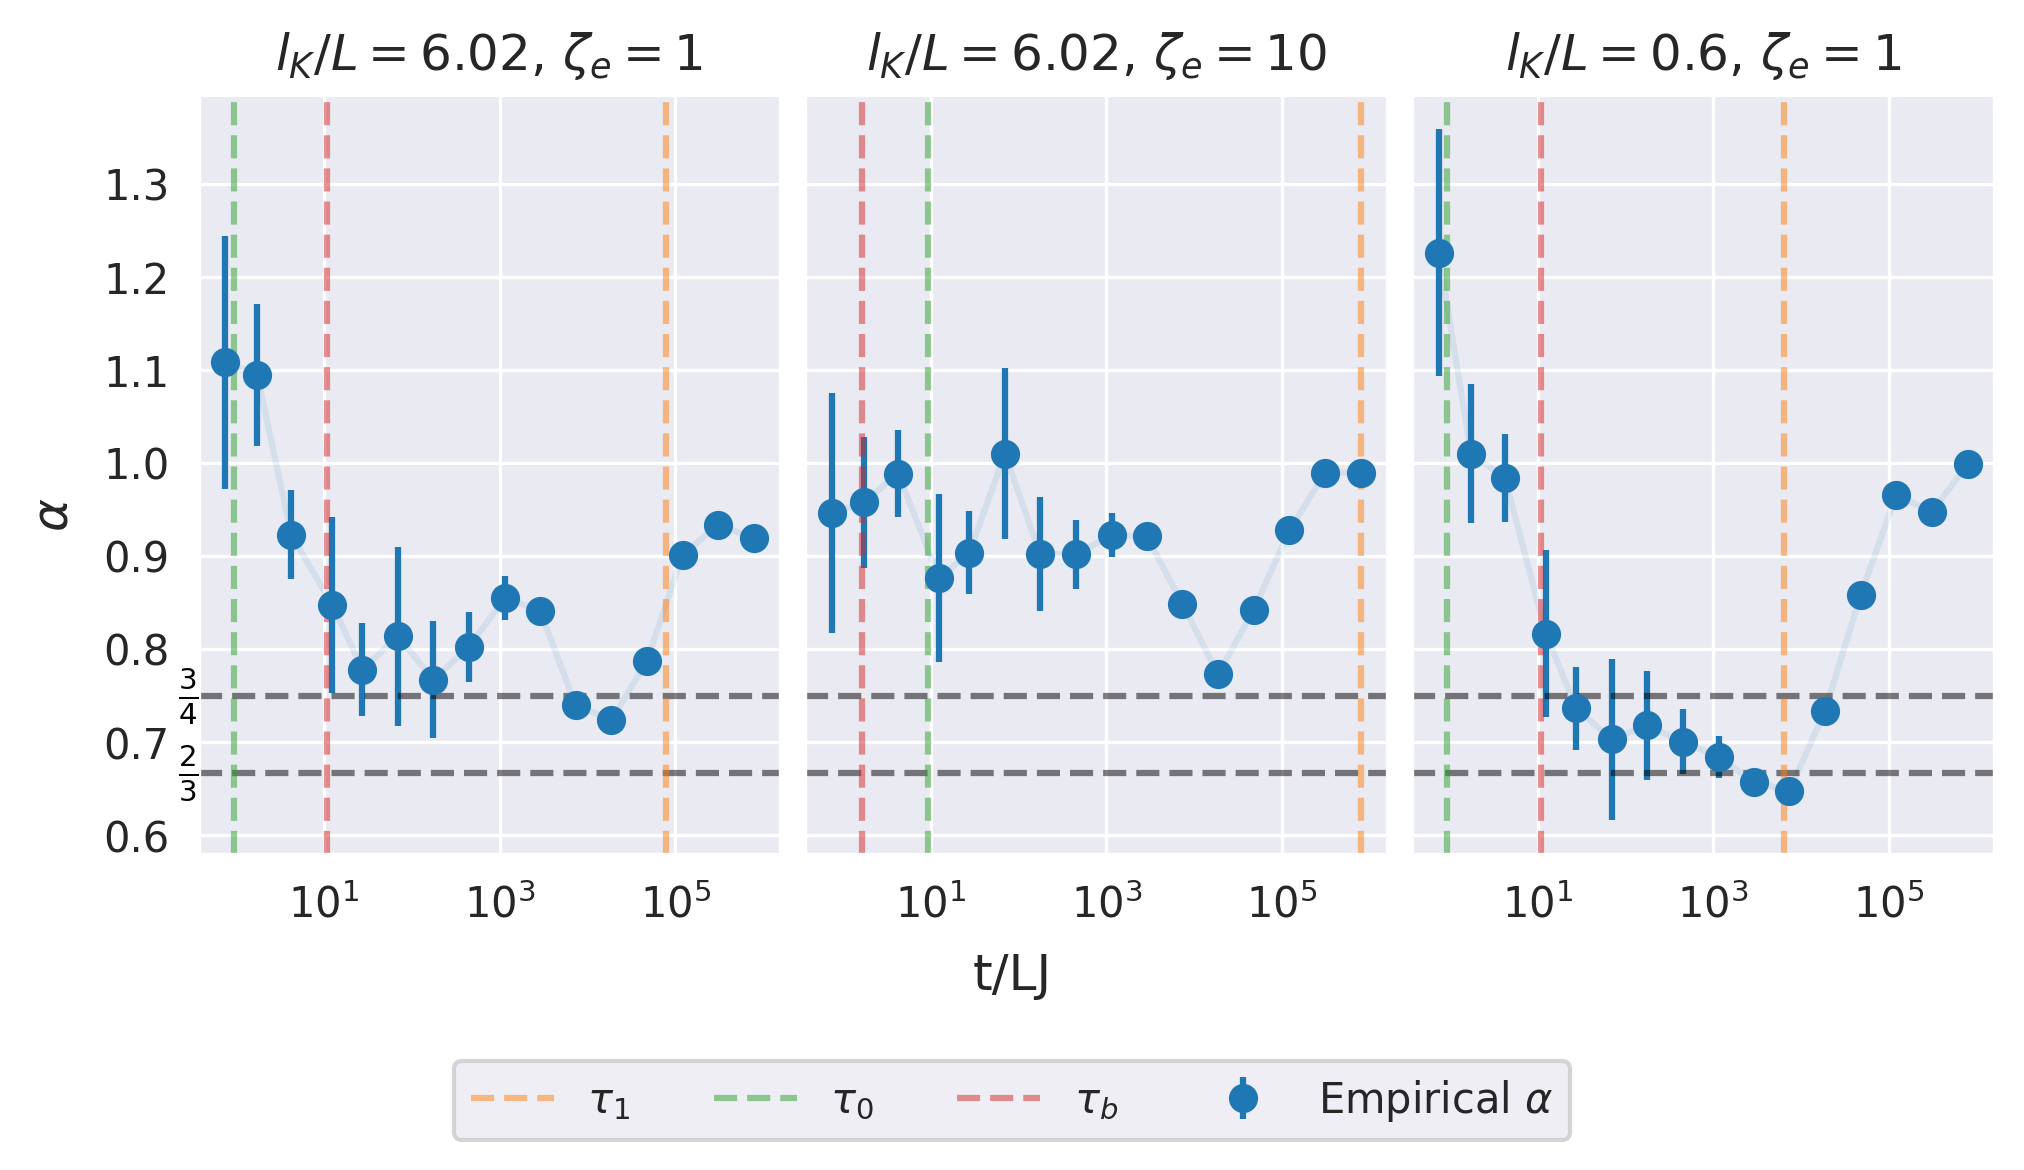

In [269]:
def estimate_alpha(
        n_bins: int, 
        viz_alpha_est: bool = False, 
        plot_error_bars: bool = True,
):
    #bins = [0, 10]+np.logspace(np.log10(1000), np.log10(1e6), base=10, num=n_bins).tolist()
    #bins = np.logspace(np.log10(1400), np.log10(2e6), num=n_bins, base=10).tolist()
    #bins = [1, 325] + bins
    #print(bins)
    
    for experiment in experiments:
        experiment["alpha"] = transform_msdlm.calculate_msd_alpha_df(
            experiment["df_msdlm"], 
            bins=None, 
            n_bins=n_bins
        )
    
    alpha_rouse = transform_msdlm.calculate_msd_alpha_df(df_rouse_msdlm, bins=bins, n_bins=n_bins)
    
    display(experiments[0]["alpha"])
    
    ax: plt.Axes
    fig, axs = plt.subplots(
        ncols=3,
        figsize=plot_utils.get_figure_size(
            width=1.0,
            n_rows=1,
            height=0.5
        ),
        sharex="all",
        sharey="all",
        layout="constrained"
    )
    
    data = []
    
    for color, experiment, ax in zip(sns.color_palette(), experiments, axs):
        experiment["alpha"] = experiment["alpha"].dropna()
        if plot_error_bars:
            ax.errorbar(
                experiment["alpha"].index,
                y=experiment["alpha"]["alpha"],
                yerr=experiment["alpha"]["delta alpha"],
                label="Empirical $\\alpha$",
                color=sns.color_palette()[0],
                marker="o",
                linestyle="none",
            )
        else:
            ax.scatter(
                experiment["alpha"].index,
                y=experiment["alpha"]["alpha"],
                label="Empirical $\\alpha$",
                color=sns.color_palette()[0],
                marker="o",
            )
            
        ax.plot(experiment["alpha"].index, experiment["alpha"]["alpha"], color=sns.color_palette()[0], alpha=0.1)
        ax.set(xscale="log", title=experiment["label"])
    
        ax.axhline(y=2 / 3, color="black", linestyle="--", alpha=0.5)
        ax.axhline(y=3 / 4, color="black", linestyle="--", alpha=0.5)
        
        tau_0=0.97**2 * experiment["zeta_e"]
        l_p = experiment["l_K"] / 2 * L_contour 
        
        if experiment["l_K"] / 2 > 1:
            tau_1 = tau_1_rod_limit(
                tau_0 = tau_0,
                L = L_contour,
                l_p=l_p,
                l_b=0.97
            )
        else:
            tau_1 = tau_1_coil_limit(
                tau_0 = tau_0,
                l_p=l_p,
                l_b=0.97
            )
            
        experiment["tau_1"] = tau_1
        
        tau_b = experiment["m_e"] / experiment["zeta_e"]
        tau_b = tau_b + 10*tau_b
        
        ax.axvline(x=tau_1, color=sns.color_palette()[1], linestyle="--", alpha=0.5, label="$\\tau_1$")
        ax.axvline(x=tau_0, color=sns.color_palette()[2], linestyle="--", alpha=0.5, label="$\\tau_0$")
        ax.axvline(x=tau_b, color=sns.color_palette()[3], linestyle="--", alpha=0.5, label="$\\tau_b$")
        
        t_left = tau_b if tau_b > tau_0 else tau_0
        t_right = tau_1
        if experiment["zeta_e"] >= 10:
            t_right = 1e5
        
        alpha_min_est_df = experiment["alpha"].loc[
            (experiment["alpha"].index >= t_left) &
            (experiment["alpha"].index <= t_right)
        ] 
        alpha_min = alpha_min_est_df["alpha"].mean()
        #alpha_min_std = alpha_min_est_df["delta alpha"].max() / (3*np.sqrt(alpha_min_est_df.shape[0]))
        alpha_min_std = alpha_min_est_df["alpha"].std() / np.sqrt(alpha_min_est_df.shape[0])
        
        alpha_row = experiment["alpha"].loc[experiment["alpha"]["alpha"].idxmin()]
        
        data.append({
            "$\\zeta_e$": experiment["zeta_e"],
            "$l_K/L$": experiment["l_K"],
            "$\\tau_1$": f"{experiment['tau_1']:.2f}",
            "$\\tau_b$": f"{tau_b:.2f}",
            "$\\tau_0$": f"{tau_0:.2f}",
            "$\\alpha_{min}$": np.round(alpha_row["alpha"], 3), 
            "$\\Delta \\alpha_{min}$": np.round(alpha_row["delta alpha"], 3),
            "$\\alpha_{m}$": np.round(alpha_min, 3), 
            "$\\Delta \\alpha_{m}$": np.round(alpha_min_std*3, 3),
            "$\\alpha_{ref}$": 3/4 if experiment["l_K"] > 1 else 2/3
        })
        
        if viz_alpha_est:
            ax.fill_between(alpha_min_est_df.index, y1=alpha_min-3*alpha_min_std, y2=alpha_min+3*alpha_min_std, alpha=0.3, color="mediumblue", label="CI of $\\alpha_{m}$")
            ax.plot(
                alpha_min_est_df.index,
                np.repeat(alpha_min, len(alpha_min_est_df)),
                linestyle="--",
                color="mediumblue",
                label="$\\alpha_{m}$"
            )
        
    
    print("Ref 2/3: ", 2/3)
    print("Ref 3/4: ", 3/4)
        
    #axs[-1].plot(alpha_rouse.index, alpha_rouse["alpha"], linestyle="-", label="Rouse", color="red")
    
    
    import matplotlib.transforms as transforms
    
    trans = transforms.blended_transform_factory(
        axs[0].get_yticklabels()[0].get_transform(),
        axs[0].transData
    )
    
    axs[0].text(
        0.05,
        2 / 3,
        "$\\frac{2}{3}$",
        color="black",
        transform=trans,
        ha="right",
        va="center"
    )
    
    axs[0].text(
        0.05,
        3 / 4,
        "$\\frac{3}{4}$",
        color="black",
        transform=trans,
        ha="right",
        va="center"
    )
    
    fig.legend(
        *axs[-1].get_legend_handles_labels(), 
        ncol=4 if not viz_alpha_est else 6, 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.15)
    )
    fig.supxlabel("t/LJ")
    fig.supylabel("$\\alpha$")
    
    df_vals = pd.DataFrame(data)
    display(df_vals)
    
    if not viz_alpha_est:
        df_vals.drop(["$\\alpha_{m}$", "$\\Delta \\alpha_{m}$", "$\\alpha_{ref}$"], inplace=True, axis="columns")
        
    print(df_vals.to_latex(index=False))
    
    return df_vals
    
df_alpha_min_vals = estimate_alpha(n_bins=18)